### Import packages

In [1]:
library(prabclus)
library(Matrix)
library(Rtsne)
library(ggplot2) 

Loading required package: MASS
Loading required package: mclust
Package 'mclust' version 5.4.3
Type 'citation("mclust")' for citing this R package in publications.


### Preprocess

`bsub < count_reads_peaks.sh`

In [2]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 12178

In [ ]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [4]:
dim(datafr)

[1] 385237  12178

In [5]:
df_regions = read.csv("../../input/combined.sorted.merged.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [6]:
dim(df_regions)

[1] 385237      3

In [7]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [8]:
head(peaknames)

[1] "chr1_3002715_3002962" "chr1_3037090_3037634" "chr1_3084622_3085850"
[4] "chr1_3103610_3104006" "chr1_3106869_3107182" "chr1_3109389_3111052"

In [9]:
head(sapply(strsplit(files,'\\.'),'[', 2))

[1] "AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT"
[2] "AGCGATAGAATATTACTTTCCGCGGACTGTACTGAC"
[3] "AGCGATAGACCAGGCGCATGGCAGCTCGATAGAGGC"
[4] "AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC"
[5] "AGCGATAGAGGTCAGCTTGGAGTTGCGTGTACTGAC"
[6] "AGCGATAGAGTTGAATCAAAGCTAGGTTCCTATCCT"

In [11]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 2)
rownames(datafr) = peaknames

In [13]:
datafr[1:5,1:5]

,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,AGCGATAGAATATTACTTTCCGCGGACTGTACTGAC,AGCGATAGACCAGGCGCATGGCAGCTCGATAGAGGC,AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC,AGCGATAGAGGTCAGCTTGGAGTTGCGTGTACTGAC
chr1_3002715_3002962,0,0,0,0,0
chr1_3037090_3037634,0,0,0,0,0
chr1_3084622_3085850,0,0,0,0,0
chr1_3103610_3104006,0,0,0,0,0
chr1_3106869_3107182,0,0,0,0,0


In [14]:
dim(datafr)

[1] 385237  12178

In [15]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [16]:
filter_peaks <- function (datafr,cutoff = 0.01){
    binary_mat = as.matrix((datafr > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE) 
    num_cells_ncounted = Matrix::rowSums(binary_mat)
    ncounts = binary_mat[num_cells_ncounted >= dim(binary_mat)[2]*cutoff,]
    ncounts = ncounts[rowSums(ncounts) > 0,]    
    
    options(repr.plot.width=4, repr.plot.height=4)
    hist(log10(num_cells_ncounted),main="No. of Cells Each Site is Observed In",breaks=50)
    abline(v=log10(min(num_cells_ncounted[num_cells_ncounted >= dim(binary_mat)[2]*cutoff])),lwd=2,col="indianred")
#     hist(log10(new_counts),main="Number of Sites Each Cell Uses",breaks=50)
    datafr_filtered = datafr[rownames(ncounts),]
    return(datafr_filtered)
}


getJaccardDist <- function(cdBinary){
        
    if(colnames(cdBinary[,2:3])[1] == 'start' && colnames(cdBinary[,2:3])[2] == 'end'){
        SingleCell.Binary <- cdBinary[,4:(dim(cdBinary)[2])]
    }
    else
        SingleCell.Binary <- cdBinary
    
    
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(SingleCell.Binary))
    
    return(SingleCell.Binary.Jaccard)
}


plot_tSNE <- function(cdBinary, nDimToUSE, groups=NULL, cellName, perplexity_division, ret.val=FALSE , text.label=FALSE, title=""){

    if(missing(nDimToUSE)){
        stop("ERROR: Number of PCA's \"nDimToUSE\" to use is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    if(missing(perplexity_division)){
        stop("ERROR: Please enter the number with which you want to divide the dimension of your data for perplexity setting")
    }
        
    
    #SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    #FinalPCAData <- t(SingleCell.Binary.Jaccard)
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=nDimToUSE)

    #pcaPRComp <- prcomp(FinalPCAData)

    
    #rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:nPCAToUSE]), perplexity = dim(pcaPRComp$x)[1]/perplexity_division, check_duplicates = FALSE)
    rtsne_pca_out <- Rtsne(as.matrix(fit$points[,1:nDimToUSE]), perplexity = perplexity_division, 
                           check_duplicates = FALSE, pca=FALSE, theta=0.01, max_iter=3000)
    
    if(is.null(groups)){
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2])
        p1 <- ggplot(df, aes_string(x="X",y ="Y"))
    }
    else{
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups, cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
        p1 <- ggplot(df, aes_string(x="X",y ="Y", color="Batch"))
    }
    

    p1<-p1 + ggtitle("t-SNE plot")
    p1<-p1 + geom_point(size = 2) 
    p1<-p1 + xlab(paste("Dim-1"))
    p1<-p1 + ylab("Dim-2")+
        theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
#     if(length(levels(groups)) < 12)
#         p1 <- p1 + scale_colour_brewer(palette="Set1")
    if(text.label==TRUE)
        p1<-p1 + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
    print(p1)
    return(df)
}

### Obtain Feature Matrix

In [17]:
start_time <- Sys.time()

In [18]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

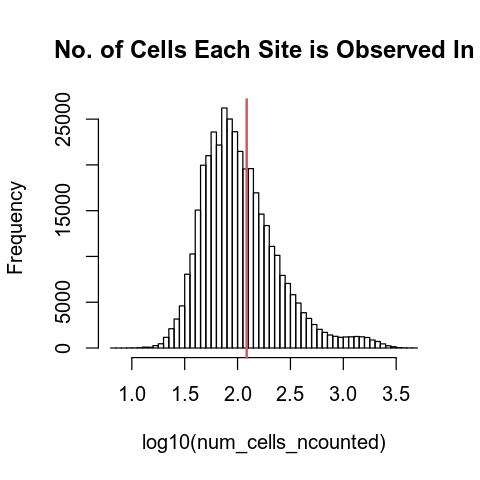

In [19]:
datafr_filtered <- filter_peaks(datafr)

In [20]:
dim(datafr_filtered)

[1] 142902  12178

In [21]:
cdBinary = as.matrix((datafr_filtered > 0) + 0)
cdBinary = Matrix(cdBinary, sparse = TRUE) 

In [22]:
## use the similar number of dimensions as shown in tutorial https://github.com/ManchesterBioinference/Scasat/blob/master/ScAsAT_functions_Buenrostro_All_Bam_Together.ipynb
k = 15
SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)
fm_Scasat = t(fit$points)

In [23]:
dim(fm_Scasat)
fm_Scasat[1:5,1:5]

[1]    15 12178

AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,AGCGATAGAATATTACTTTCCGCGGACTGTACTGAC,AGCGATAGACCAGGCGCATGGCAGCTCGATAGAGGC,AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC,AGCGATAGAGGTCAGCTTGGAGTTGCGTGTACTGAC
-0.0693169608,-0.001079940,0.05696282,-0.065644888,-0.031449504
-0.0443283211,-0.042154498,0.06296769,-0.035717455,-0.091638930
0.0100248533,0.003686067,0.02084601,-0.001086196,0.005620094
0.0211283651,0.010922273,0.04571905,-0.015908019,-0.011147807
0.0004866456,-0.021881967,-0.01661780,-0.010943796,-0.060683427


In [24]:
end_time <- Sys.time()

In [25]:
end_time - start_time

Time difference of 10.8073 mins

In [26]:
rownames(fm_Scasat) = paste('Dim',1:dim(fm_Scasat)[1])
fm_Scasat[1:5,1:5]

,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,AGCGATAGAATATTACTTTCCGCGGACTGTACTGAC,AGCGATAGACCAGGCGCATGGCAGCTCGATAGAGGC,AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC,AGCGATAGAGGTCAGCTTGGAGTTGCGTGTACTGAC
Dim 1,-0.0693169608,-0.001079940,0.05696282,-0.065644888,-0.031449504
Dim 2,-0.0443283211,-0.042154498,0.06296769,-0.035717455,-0.091638930
Dim 3,0.0100248533,0.003686067,0.02084601,-0.001086196,0.005620094
Dim 4,0.0211283651,0.010922273,0.04571905,-0.015908019,-0.011147807
Dim 5,0.0004866456,-0.021881967,-0.01661780,-0.010943796,-0.060683427


In [27]:
all(colnames(fm_Scasat) == rownames(metadata))

[1] FALSE

In [28]:
fm_Scasat = fm_Scasat[,rownames(metadata)]
dim(fm_Scasat)

[1]    15 12178

In [30]:
all(colnames(fm_Scasat) == rownames(metadata))

[1] TRUE

In [31]:
saveRDS(fm_Scasat, file = '../../output/feature_matrices/FM_Scasat_cusanovich2018subset.rds')

### Downstream Analysis

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)
set.seed(2019)
tsNE_out_2PCs <- plot_tSNE(cdBinary, k, groups=metadata$label, perplexity=30, 
                              cellName=rownames(metadata),ret.val=TRUE, text.label=F)

In [ ]:
sessionInfo()

In [ ]:
save.image(file = 'Scasat_cusanovich2018subset.RData')